In [154]:
library('pcalg')
library('glasso')
library('ggplot2')
library('reshape2')
library('network')
library('mice')
library('VIM')
library('igraph')


Attaching package: ‘igraph’

The following objects are masked from ‘package:network’:

    %c%, %s%, add.edges, add.vertices, delete.edges, delete.vertices,
    get.edge.attribute, get.edges, get.vertex.attribute, is.bipartite,
    is.directed, list.edge.attributes, list.vertex.attributes,
    set.edge.attribute, set.vertex.attribute

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



# Experiments with Complete Data

### Loading data

In [176]:
df <- read.table("data.txt", header = TRUE)

In [14]:
head(df, n=5)

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20
1.3350145,-1.0309613,-0.548072338,1.3360743,-3.6254374,0.1226852,0.6618629,-1.5850715,-0.08598698,1.0256022,-2.204094501,-1.4335640,0.5508215,-2.7181090,-1.395785,-5.247183,-8.074484,-1.9950202,-4.605475,-3.2646799
2.7329641,1.5760198,-0.387677590,2.3118157,1.5040188,-0.0382246,-2.6035891,1.1090277,1.96040573,2.2445068,2.335707414,0.7391094,3.0734144,3.2402806,1.908914,5.560304,9.819726,3.5067296,4.663656,1.9759823
-0.4193910,0.5307290,-0.005642063,0.3577237,0.2054322,-1.1547866,1.0709198,-0.5897830,2.14863581,1.9423736,2.473610575,-0.8899228,-0.2954322,2.4367608,1.048712,2.057625,4.131040,-0.4947517,5.538459,0.7131947
-0.8833457,1.0293073,0.139632453,0.2313947,1.2330777,-0.2206726,-0.8867674,0.9686662,-0.10819051,-0.4638227,-0.007166879,-1.0761528,0.6934186,0.6462034,1.369925,1.244228,1.666682,1.8185776,-2.199849,1.1349060
-0.3809976,-0.1857435,0.690732171,-0.2645569,-1.0482979,2.0346526,-1.2476075,2.3427174,-2.53591082,1.6865435,1.979284445,1.3001764,3.7432045,-0.8376404,1.209384,3.345439,4.863806,-0.6987201,3.266726,-0.7156618


### Estimating CP-DAG using PC algorithm

We now fit a CP-DAG to the given data using the PC algorithm. Since we know that the data was generated from a Gaussian distribution, we use the Gaussian conditional independence test here. We also experiment with several values of the hyperparameter alpha and report the number of total, directed, and undirected edges in the obtained CP-DAGs.

In [74]:
n <- nrow(df)
V <- colnames(df)

## estimate CPDAG
pc.fit <- pc(suffStat = list(C = cor(df), n = n),
             indepTest = gaussCItest,
             alpha=0.01, labels = V, verbose = FALSE)

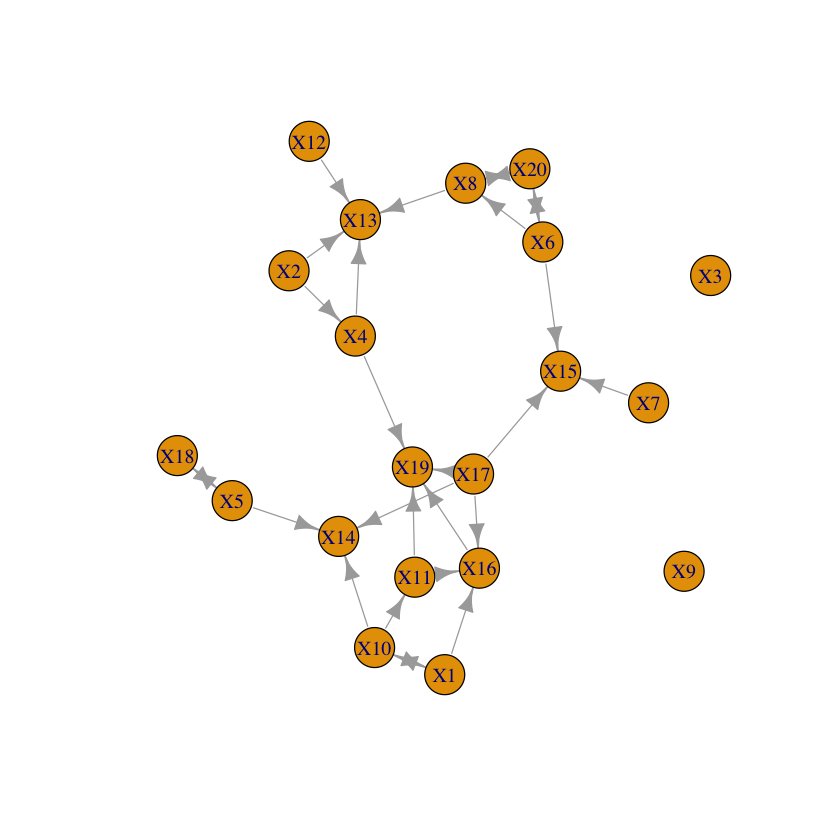

In [69]:
iplotPC(pc.fit)

In [70]:
pc.fit

Object of class 'pcAlgo', from Call:
pc(suffStat = list(C = cor(df), n = n), indepTest = gaussCItest, 
    alpha = 0.01, labels = V, verbose = TRUE)
Number of undirected edges:  4 
Number of directed edges:    20 
Total number of edges:       24 

##### Plot of number of edges versus alpha

In [71]:
pc.edges <- read.table('pc_results.txt', header=TRUE)

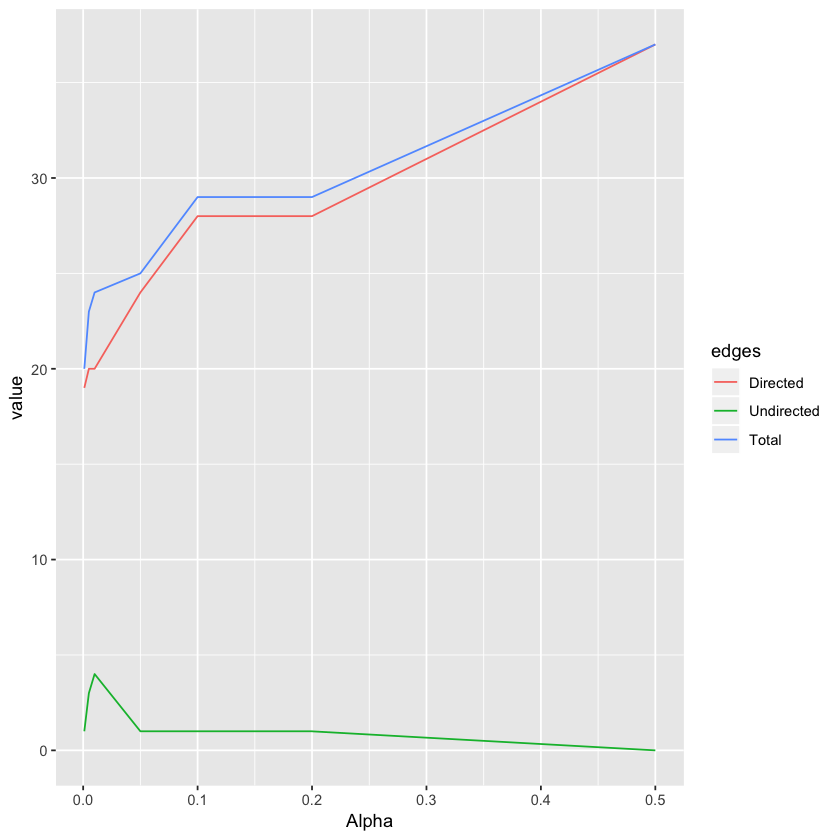

In [81]:
pc.df <- melt(pc.edges ,  id.vars = 'Alpha', variable.name = 'edges')
ggplot(pc.df, aes(Alpha,value)) + geom_line(aes(colour = edges))

### Estimating undirected graph using Glasso algorithm

In [177]:
glasso.fit <- glasso(var(df), 0.5)

P <- glasso.fit$wi
A <- ifelse(P!=0 & row(P)!=col(P),1,0)

glasso.fit.graph <- network(A)

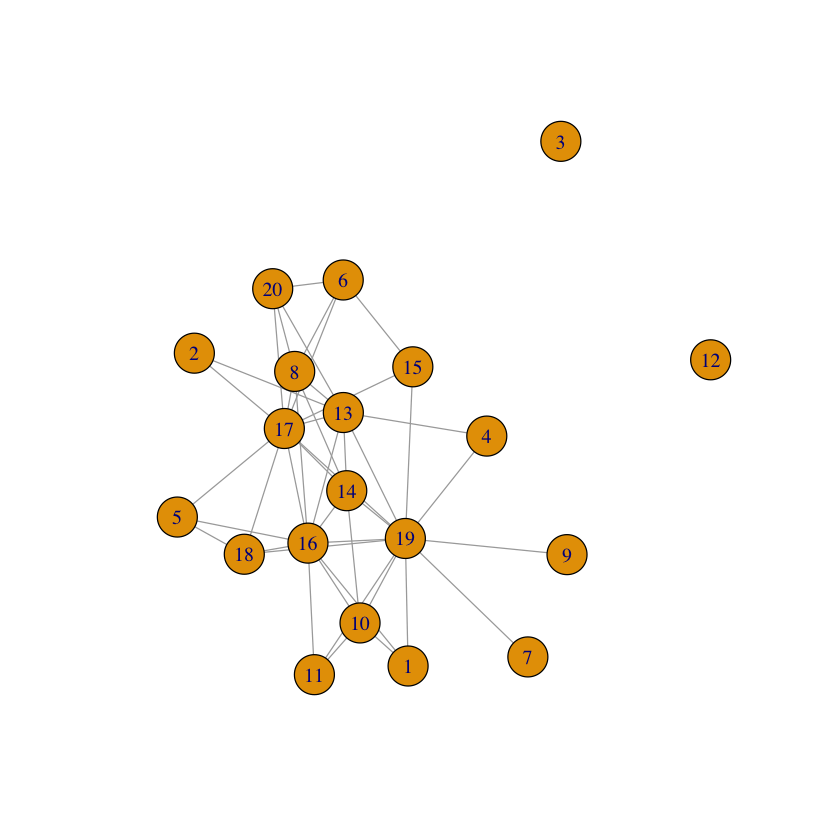

In [179]:
glasso.graph <- graph_from_adjacency_matrix(as(glasso.fit.graph,"matrix"), mode = 'undirected', weighted = NULL, diag = TRUE,
  add.colnames = NULL, add.rownames = NA)
plot.igraph(glasso.graph)

##### Plot of number of edges versus lambda

In [110]:
get_num_edges <- function(df, lambda){
    glasso.fit <- glasso(var(df), lambda)

    P <- glasso.fit$wi
    A <- ifelse(P!=0 & row(P)!=col(P),1,0)

    glasso.fit.graph <- network(A)
    return (glasso.fit.graph$gal$mnext)
}

In [114]:
lseq <- function(from=0.001, to=1, length.out=6) {
  # logarithmic spaced sequence
  # blatantly stolen from library("emdbook"), because need only this
  exp(seq(log(from), log(to), length.out = length.out))
}

In [115]:
lambdas <- lseq(length.out=10)
edges <- numeric(0)
for (lambda in lambdas){
    num_edges <- get_num_edges(df, lambda)
    edges <- c(edges, num_edges)
}

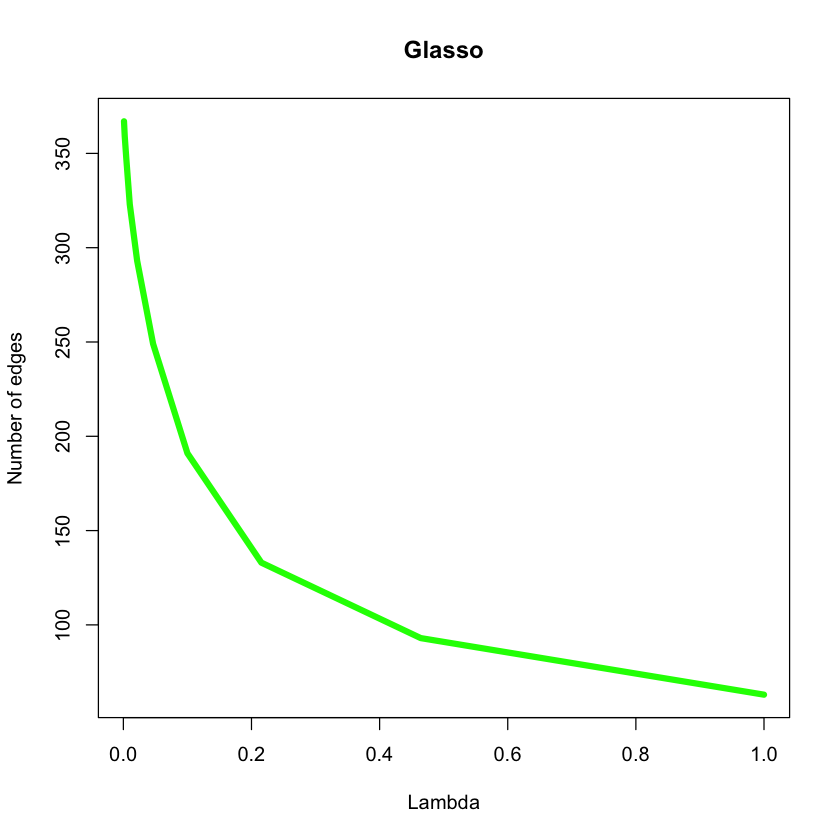

In [117]:
plot(lambdas,edges, type="l", col="green", lwd=5, xlab="Lambda", ylab="Number of edges", main="Glasso")

It can be seen that as we increase the value of regularization parameter Lambda, the number of edges decreases.

# Experiments with Missing Data

### Loading data

Let us first look at the data and observe some patterns of missingness.

In [120]:
df <- read.table("data_missing.txt", header = TRUE)
head(df, n=5)

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20
0.0278827,-0.1707617,-1.5765290,NA,1.2746497,1.7304177,0.96940026,NA,2.2136752,0.2499064,0.7771605,-2.9525108,2.3937912,NA,1.0262830,2.9613704,4.591843,NA,5.638896,3.4027011
1.4137088,-0.9186285,0.3550805,-0.8819086,NA,0.7738512,0.02736936,1.63192568,-0.4748327,1.1130907,-0.7495604,-1.1934266,0.9131823,1.494185,0.3901498,1.9476168,2.269049,NA,1.113019,0.9925184
1.9827306,-0.3263905,-0.7088189,NA,0.4738939,0.9808876,-0.61359643,1.31524170,3.6348010,1.8057390,0.5497847,-0.3025660,3.4643770,NA,1.3417157,3.1979860,5.097269,NA,3.794281,0.5911714
0.6457511,0.5866771,2.2477254,NA,-0.9739825,0.7176597,-0.85950516,1.98760134,-1.8508324,0.4002269,0.9053712,0.8144857,3.1832295,NA,0.4031432,0.3372564,1.736045,NA,2.775438,1.2598296
-0.2552803,-0.3784124,0.3774816,-0.2976657,-0.8357225,-0.4253966,0.88780652,-0.07187634,0.8677890,-0.2718426,NA,NA,-1.0895877,NA,-0.6240573,-0.9810125,NA,-2.465306,-1.424055,0.7062528


Warning message in plot.aggr(res, ...):
“not enough vertical space to display frequencies (too many combinations)”


 Variables sorted by number of missings: 
 Variable Count
      X14 0.660
       X1 0.526
       X5 0.520
       X8 0.514
       X4 0.494
      X11 0.488
       X2 0.486
      X12 0.482
      X18 0.468
      X17 0.464
       X3 0.000
       X6 0.000
       X7 0.000
       X9 0.000
      X10 0.000
      X13 0.000
      X15 0.000
      X16 0.000
      X19 0.000
      X20 0.000


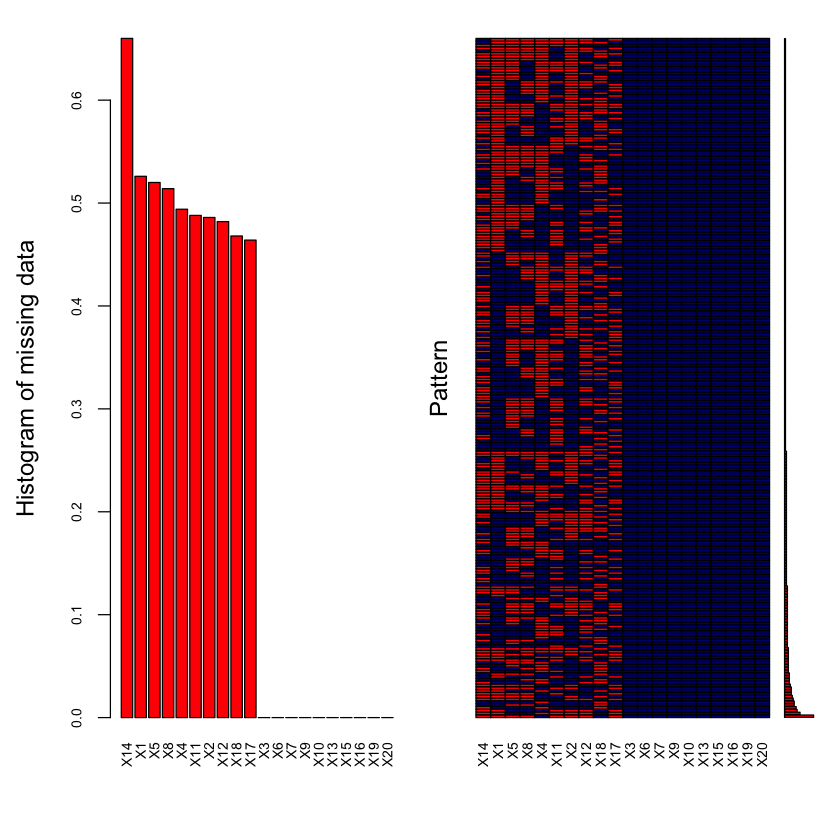

In [129]:
aggr_plot <- aggr(df, col=c('navyblue','red'), numbers=TRUE, sortVars=TRUE, labels=names(df), cex.axis=.7, gap=3, 
                  ylab=c("Histogram of missing data","Pattern"))

As we can see in the figure above, only about half of the features have missing data in them.

### Data imputation using MICE

In [134]:
df_imputed <- mice(df, m=10)
summary(df_imputed)


 iter imp variable
  1   1  X1  X2  X4  X5  X8  X11  X12  X14  X17  X18
  1   2  X1  X2  X4  X5  X8  X11  X12  X14  X17  X18
  1   3  X1  X2  X4  X5  X8  X11  X12  X14  X17  X18
  1   4  X1  X2  X4  X5  X8  X11  X12  X14  X17  X18
  1   5  X1  X2  X4  X5  X8  X11  X12  X14  X17  X18
  1   6  X1  X2  X4  X5  X8  X11  X12  X14  X17  X18
  1   7  X1  X2  X4  X5  X8  X11  X12  X14  X17  X18
  1   8  X1  X2  X4  X5  X8  X11  X12  X14  X17  X18
  1   9  X1  X2  X4  X5  X8  X11  X12  X14  X17  X18
  1   10  X1  X2  X4  X5  X8  X11  X12  X14  X17  X18
  2   1  X1  X2  X4  X5  X8  X11  X12  X14  X17  X18
  2   2  X1  X2  X4  X5  X8  X11  X12  X14  X17  X18
  2   3  X1  X2  X4  X5  X8  X11  X12  X14  X17  X18
  2   4  X1  X2  X4  X5  X8  X11  X12  X14  X17  X18
  2   5  X1  X2  X4  X5  X8  X11  X12  X14  X17  X18
  2   6  X1  X2  X4  X5  X8  X11  X12  X14  X17  X18
  2   7  X1  X2  X4  X5  X8  X11  X12  X14  X17  X18
  2   8  X1  X2  X4  X5  X8  X11  X12  X14  X17  X18
  2   9  X1  X2  X4  X5  

Let us now look at the imputed values for one of the features, say X1. In the table below, (i,j) denotes the imputed values of X1 for the sample i in the imputation j.

In [159]:
head(df_imputed$imp$X1,n=5)

,1,2,3,4,5,6,7,8,9,10
9,0.9874039,0.71983887,1.1713960,0.6201667,0.71805313,0.9897301,0.6771213,1.0778414,0.6507328,0.9720104
10,1.3787902,0.73130237,-0.4989350,0.6021596,-0.09667912,0.6612602,0.3033335,-0.4974153,-0.2563666,1.0653214
11,0.4413739,1.20023885,0.8965719,1.4564301,-0.16892221,0.9874039,0.5827178,0.6771213,0.6021596,0.1677725
12,1.1713960,-0.04749774,0.3794101,-0.5796717,-0.09667912,-0.3115411,0.2131006,0.9432645,1.3869220,0.5949130
14,0.2429258,0.36581148,1.1605616,0.8965719,-0.31154105,0.1481084,0.4413739,0.5053975,-0.1668658,-0.4989350


### Learning CP-DAG with imputed data

In the following fitting experiments, we fix alpha at 0.01.

In [136]:
fit_PC_graph <- function(df){
    n <- nrow(df)
    V <- colnames(df)

    ## estimate CPDAG
    pc.fit <- pc(suffStat = list(C = cor(df), n = n),
                 indepTest = gaussCItest,
                 alpha=0.01, labels = V, verbose = FALSE)    
}

In [160]:
get_adj_matrix_PC <- function(df){
    pc.fit <- fit_PC_graph(df)
    return (as(pc.fit@graph,"matrix"))
}

We obtain complete data using each of the 10 imputed values. Each of these complete datasets are used to fit a CP-DAG using the PC algorithm. The resulting graph is returned as an adjacency matrix.

In [161]:
adj_mats <- list()
for (imp in seq(1:10)){
    df_complete <- complete(df_imputed, imp)
    mat <- get_adj_matrix_PC(df_complete)
    adj_mats[[imp]] <- mat
}

We now sum the adjacency matrices for all the graphs. **If an edge is present in at least 5 of the 10 CP-DAGs, it is retained in the final one**.

In [162]:
agg_adj_mat <- Reduce('+', adj_mats)
agg_adj_mat[agg_adj_mat < 5] <- 0
agg_adj_mat[agg_adj_mat > 0] <- 1

In [163]:
pc.graph <- graph_from_adjacency_matrix(agg_adj_mat, mode = c("directed", "undirected",
  "max", "min", "upper", "lower", "plus"), weighted = NULL, diag = TRUE,
  add.colnames = NULL, add.rownames = NULL)

Warning message in graph_from_adjacency_matrix(agg_adj_mat, mode = c("directed", :
“Same attribute for columns and rows, row names are ignored”

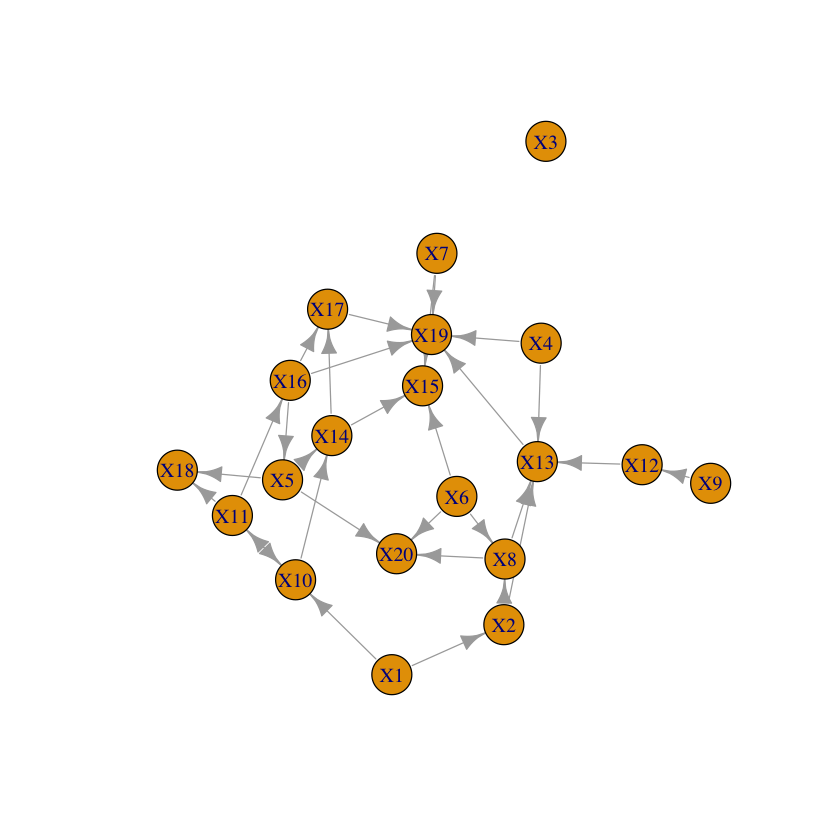

In [164]:
plot.igraph(pc.graph)

As we can see from the above graph, most of the causal behaviour is retained despite the fact that all the samples had missing values in them. For example, we can notice that X3 is isolated from all other nodes, as was the case in the full data CP-DAG.

### Learning undirected graph from the imputed data

In the following experiments, we fix the value of Lambda as 0.5, since this was observed to give a relatively sparse graph, matching with that obtained from the PC algorithm. We use the same aggregation logic as in the PC method above, where, if an edge is present in at least 5 of the 10 imputed graphs, it is retained in the final graph, and deleted otherwise.

In [165]:
fit_glasso_graph <- function(df){
    glasso.fit <- glasso(var(df), 0.5)

    P <- glasso.fit$wi
    A <- ifelse(P!=0 & row(P)!=col(P),1,0)

    glasso.fit.graph <- network(A)
    return (glasso.fit.graph)
}

In [166]:
get_adj_matrix_glasso <- function(df){
    glasso.fit <- fit_glasso_graph(df)
    return (as(glasso.fit,"matrix"))
}

In [167]:
adj_mats_glasso <- list()
for (imp in seq(1:10)){
    df_complete <- complete(df_imputed, imp)
    mat <- get_adj_matrix_glasso(df_complete)
    adj_mats_glasso[[imp]] <- mat
}

In [168]:
agg_adj_mat_glasso <- Reduce('+', adj_mats_glasso)
agg_adj_mat_glasso[agg_adj_mat_glasso < 5] <- 0
agg_adj_mat_glasso[agg_adj_mat_glasso > 0] <- 1

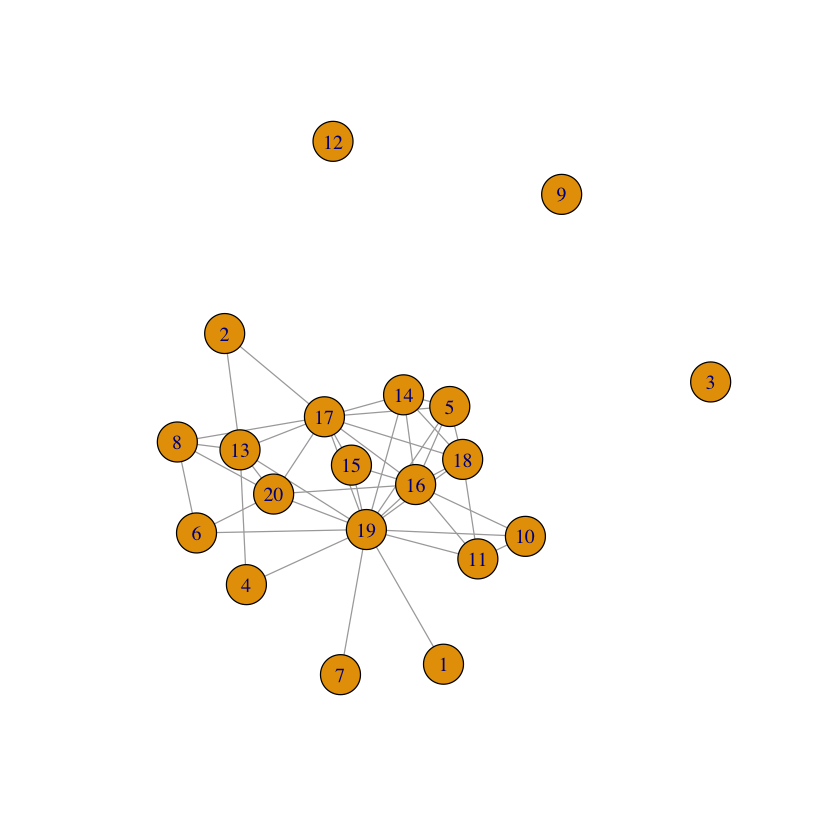

In [171]:
glasso.graph <- graph_from_adjacency_matrix(agg_adj_mat_glasso, mode = 'undirected', weighted = NULL, diag = TRUE,
  add.colnames = NULL, add.rownames = NA)
plot.igraph(glasso.graph)

Again, it is evident that the imputed data retains most of the relationships of the full dataset.